In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
from tqdm import tqdm
import networkx as nx
from hypnf import *

### Generate synthetic network

In [69]:
N_n = 500
beta = 1.5
gamma = 2.7
kmean = 20

N_f = 200
beta_b = 3
gamma_n = 2.5
gamma_f = 2.1
kmean_n = 5

N_c = 3
alpha = 5

In [70]:
net = HypNF(N_n, beta, gamma, kmean,
            N_f, beta_b, gamma_n, gamma_f, kmean_n,
            N_c, alpha)
net

HypNF(N_n=500, beta=1.5, gamma=2.7, kmean=20, N_f=200, beta_b=3, gamma_n=2.5, gamma_f=2.1, kmean_n=5, N_c=3, alpha=5)

In [71]:
data = net()
data

Data(x=[500, 200], edge_index=[2, 7946], y=[500], thetas=[500], kappas=[500], radii=[500], thetas_f=[200], kappas_f=[200], kappas_n=[500], radii_n=[500], radii_f=[200], num_nodes=500, num_node_features=200, num_classes=3)

In [72]:
from torch_geometric.utils import to_networkx
g = to_networkx(data, to_undirected=True, node_attrs=['thetas', 'kappas', 'radii', 'y'])
print(g)

Graph with 500 nodes and 3973 edges


100%|█████████████████████████████████████████████████████████| 3973/3973 [00:00<00:00, 5771.54it/s]


Text(0.5, 1.0, 'Unipartite network')

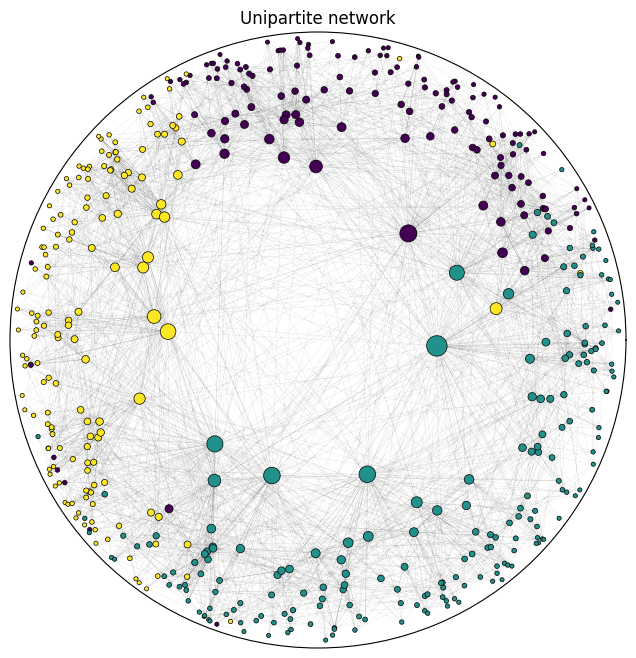

In [73]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

for source, target in tqdm(g.edges()):
    s = g.nodes[source]
    t = g.nodes[target] 
    ax.plot([s['thetas'], t['thetas']], [s['radii'], t['radii']], 
            color='black', alpha=0.3, linewidth=0.1)

thetas = nx.get_node_attributes(g, 'thetas').values()
radii = list(nx.get_node_attributes(g, 'radii').values())
kappas = list(nx.get_node_attributes(g, 'kappas').values())
labels = list(nx.get_node_attributes(g, 'y').values())

ax.scatter(thetas, radii, c=labels, edgecolors='black',
           s=kappas, alpha=1, linewidths=0.5, zorder=30)

ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(0, np.max(radii) + 0.2)
ax.set_title('Unipartite network')

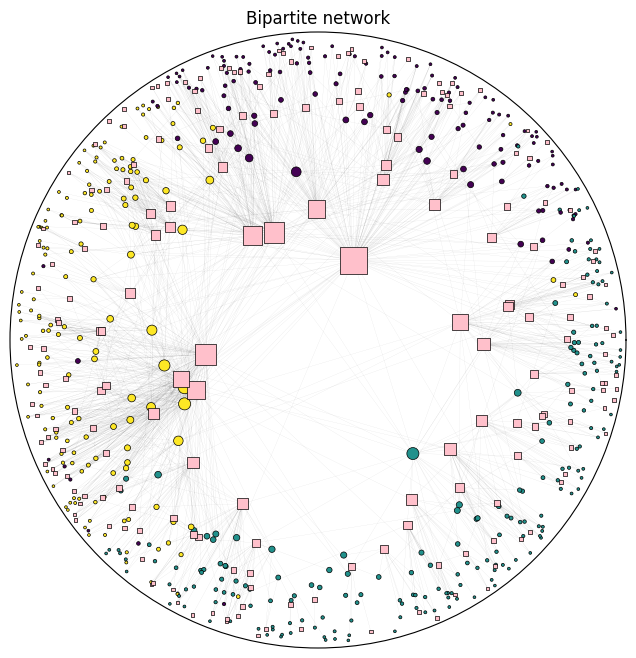

In [74]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

thetas_n = data.thetas
radii_n = data.radii_n
kappas_n = np.array(data.kappas_n)
labels = data.y

thetas_f = data.thetas_f
radii_f = data.radii_f
kappas_f = np.array(data.kappas_f)

for s, t in torch.nonzero(data.x):
    ax.plot([thetas_n[s], thetas_f[t]], [radii_n[s], radii_f[t]], 
            color='black', alpha=0.2, linewidth=0.1)

ax.scatter(thetas_n, radii_n, c=labels, edgecolors='black',
           s=2*kappas_n, alpha=1, linewidths=0.5, zorder=30)
ax.scatter(thetas_f, radii_f, marker='s', edgecolors='black',
           alpha=1, s=2*kappas_f, color='pink',linewidths=0.5, zorder=30)

ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(0, np.max(radii_n) + 0.2)
ax.set_title('Bipartite network')
plt.show()

### Define a GCN model for node classification task

In [75]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


class GCNNodeClassification(torch.nn.Module):
    def __init__(self, data, hidden_dim):
        super().__init__()
        self.data = data
        self.conv1 = GCNConv(self.data.num_node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, self.data.num_classes)

    def forward(self):
        x, edge_index = self.data.x, self.data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [76]:
from torch_geometric.transforms import RandomNodeSplit

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Split the dataset
num_train_per_class = 20
num_val = int(0.1 * len(data.y))
num_test = int(0.2 * len(data.y)) 
randomTrainTestSplit = RandomNodeSplit(split='random', num_train_per_class=num_train_per_class,
                                       num_val=num_val, num_test=num_test)
new_data = randomTrainTestSplit(data).to(device)
model = GCNNodeClassification(new_data, 16)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train(data):
    model.train()        
    optimizer.zero_grad()
    out = model()
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.detach().cpu().numpy()

def test(data):
    model.eval()
    pred = model().argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc

epochs = 200
pbar = tqdm(list(range(1, epochs + 1)))
for epoch in pbar:
    loss = train(new_data)
    acc = test(new_data)
    pbar.set_description('Epoch: {:03d}, Loss: {:.4f}, ACC (test): {:.4f}'.format(epoch, loss, acc))

Epoch: 200, Loss: 0.0509, ACC (test): 0.8500: 100%|██████████████| 200/200 [00:00<00:00, 233.79it/s]


### Define a GCN model for link prediction task

In [77]:
class GCNLinkPrediction(torch.nn.Module):
    # https://github.com/pyg-team/pytorch_geometric/blob/master/examples/link_pred.py
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [78]:
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score
from torch_geometric.transforms import RandomLinkSplit

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNLinkPrediction(data.num_node_features, 16, 4)
model = model.to(device)

data_lp = data.to(device)
randomTrainTestSplit = RandomLinkSplit(num_val=0.05, num_test=0.1, 
                                       is_undirected=True, add_negative_train_samples=False)
train_data, val_data, test_data = randomTrainTestSplit(data_lp)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss.detach().cpu().numpy()

@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

best_val_auc = final_test_auc = 0
pbar = tqdm(list(range(1, epochs + 1)))

for epoch in pbar:
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    pbar.set_description(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
        f'Test: {test_auc:.4f}')

Epoch: 200, Loss: 0.5037, Val: 0.8519, Test: 0.8539: 100%|███████| 200/200 [00:01<00:00, 112.70it/s]
